In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression

We first read the data from the CSVs and seperate by the label (TenYearCHD or The 10 year risk of coronary heart disease(CHD)), categorical variables, and numeric variables.

In [36]:
test_data, train_data = pd.read_csv('fhs_test.csv'), pd.read_csv('fhs_train.csv')

y = 'TenYearCHD'
cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

Before we do any processing, we wanted to get a brief overview of the data and see if it needs to be manipulated or cleaned in anyway.


In [58]:
print("Summary statistics: \n")
print(train_data.describe(), "\n")

print("Missing values: \n")
print(train_data.isnull().sum(), "\n")

print("Distinct values: \n")
for column in cat_vars:
    print(f"{column}: {train_data[column].unique()}")

print("Data types: \n")
print(train_data.dtypes, "\n")

print(f"TenYearCHD: {train_data['TenYearCHD'].unique()}")

Summary statistics: 

        Unnamed: 0          sex          age    education  currentSmoker  \
count  3180.000000  3180.000000  3180.000000  3095.000000    3180.000000   
mean   2129.740881     0.433019    49.633962     1.957027       0.490881   
std    1231.779357     0.495571     8.557596     1.011135       0.499995   
min       1.000000     0.000000    32.000000     1.000000       0.000000   
25%    1062.750000     0.000000    42.000000     1.000000       0.000000   
50%    2137.500000     0.000000    49.000000     2.000000       0.000000   
75%    3209.250000     1.000000    56.000000     3.000000       1.000000   
max    4240.000000     1.000000    70.000000     4.000000       1.000000   

        cigsPerDay       BPMeds  prevalentStroke  prevalentHyp     diabetes  \
count  3156.000000  3180.000000      3180.000000   3180.000000  3180.000000   
mean      8.970532     0.029245         0.006604      0.321069     0.026101   
std      12.013704     0.168520         0.081008      0.

We wanted some visualization as well so we created a heatmap of the correlation between variables.

<Axes: >

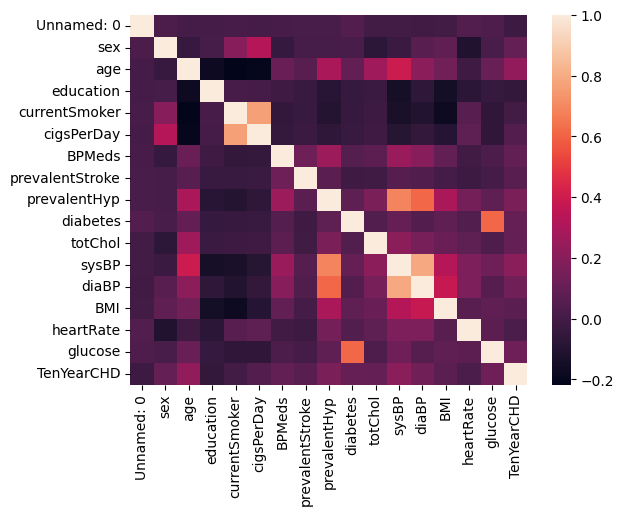

In [38]:
train_data_corr = train_data.corr()
sns.heatmap(train_data_corr)

We notice a few things by doing this. Firstly, what was presumably a column for IDing the patients is still included in the data ("Unnamed: 0"). This will have to be dropped. In addition, from the heat map we can see that while nothing correlates to strongly with the label (looking at the bottom row), education actually has the worst correlation near 0. We'll drop this as well.





In [24]:
train_data = train_data.drop(['Unnamed: 0', 'education'], axis=1)
test_data = test_data.drop(['Unnamed: 0', 'education'], axis=1)
cat_vars = ['sex', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

Moreover, the variables cigsPerDay, BPMeds, totChol, BMI, and glucose all have missing values. For the numeric variables, we'll handle this within our pipeline by using an imputer to calculate some value to replace the missing values with. This is a better option than dropping the rows with missing data since it means we'll still be able to use it to train. For the categorical variables with missing variables, there was only BPMeds after we dropped education. The categories for this variable was 0 and 1. To fill the NAs we replaced them with 0s since BPMeds represented a boolean, you either did take medication or you didn't and since the majority didn't (had 0), this was a suitable replacement for the missing values as well.

Additionally, for the categorial variables, we noticed that they are floats, not strings. This shouldn't be a problem, however, as we plan to use a OneHotEncoder anyways to transform the categorical data which should seperate the different distinct values regardless. This also solves our problem with missing values for them as well since NAs will just be represented as their own column in the resulting matrix.

Apart from these small observations, the numeric data will be transformed in the pipeline, as we said, and there were no other noticeable problems with the categorical data so there wasn't any more cleaning we chose to do.

In [39]:
train_data[['BPMeds']] = train_data[['BPMeds']].fillna(0)
test_data[['BPMeds']] = test_data[['BPMeds']].fillna(0)

## Model Pipeline

Here were defining a function that given our categorical and numeric variables we select, creates pipelines for a LinearRegressor, Logistic Regressor, and DecisionTreeClassifier.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

def pipe(cat_vars, num_vars):

    #set up variable preprocessing:
    X_vars = cat_vars + num_vars
    cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))])
    num_pipeline = Pipeline(steps = [('maxmin', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

    #column transformer:
    preprocessor = ColumnTransformer(transformers = [('cat', cat_pipeline, cat_vars), ('num', num_pipeline, num_vars)])

    #create model specific pipelines:
    lm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LinearRegression(fit_intercept=False))])
    lr_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LogisticRegression())])
    tree_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(max_depth = 4))])

    #split train-test data
    X_train = train_data.loc[:, X_vars]
    X_test = test_data.loc[:, X_vars]
    y_train = train_data[y]
    y_test = test_data[y]

    #fit the models
    lm = lm_pipe.fit(X_train, y_train)
    lr = lr_pipe.fit(X_train, y_train)
    tree = tree_pipe.fit(X_train, y_train)

    #results:

    # LINEAR REGRESSION

    print('Linear Model rsq: ', lm.score(X_test, y_test) ) # R-squared
    y_hat_lm = lm.predict(X_test) # Predicted values

    print('Slope Coefficients: ', lm_pipe.named_steps['linreg'].coef_) # Regression coefficients
    print('Intercept: ', lm_pipe.named_steps['linreg'].intercept_) # Regression coefficients

    plt.scatter(x=y_hat_lm,y=y_test)
    plt.title('Linear Model: Predicted vs. Actual Values')
    plt.show()

    sns.kdeplot(x=y_test - y_hat_lm).set_title('Linear Model: Residuals')
    plt.show()

    # LOGISTIC REGRESSION

    print(f'\nLogistic Regression rsq: {lr.score(X_test, y_test)}') # R-squared

    # DECISION TREE

    print('\nTree rsq: ', tree.score(X_test, y_test) ) # R-squared
    y_hat_tree = tree.predict(X_test)

    tab = pd.crosstab(y_test,y_hat_tree) # Compute confusion matrix
    acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
    print('Confusion Matrix:', '\n',pd.crosstab(y_test,y_hat_tree))

    plot_tree(tree_pipe.named_steps['tree'],filled=True)
    plt.show()

    # plt.scatter(x=y_hat_tree,y=y_test)
    # plt.title('Tree: Predicted vs. Actual Values')
    # plt.show()

    sns.kdeplot(x=y_test - y_hat_tree).set_title('Tree: Residuals')
    plt.show()


Linear Model rsq:  0.0869703379513711
Slope Coefficients:  [-1.91175051e+12 -1.91175051e+12 -1.45638615e+12 -1.45638615e+12
 -1.45638615e+12 -1.45638615e+12 -1.45638615e+12 -1.17030589e+12
 -1.17030589e+12  3.06962026e+12  3.06962026e+12 -2.46958118e+12
 -2.46958118e+12  8.76242287e+10  8.76242287e+10  3.85077923e+12
  3.85077923e+12  5.66329956e-02  3.37524414e-02  1.20849609e-02
  5.13572693e-02 -1.92413330e-02 -1.60217285e-03  1.40380859e-03
  2.62756348e-02]
Intercept:  0.0


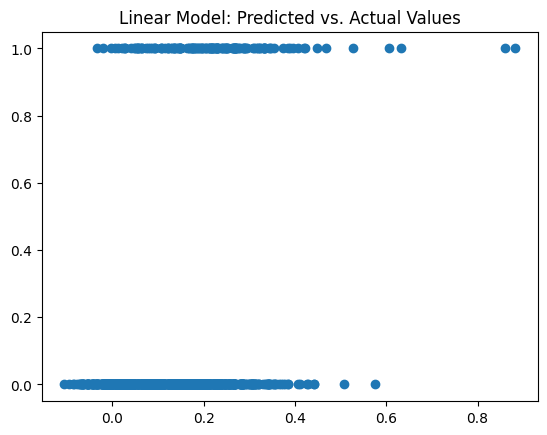

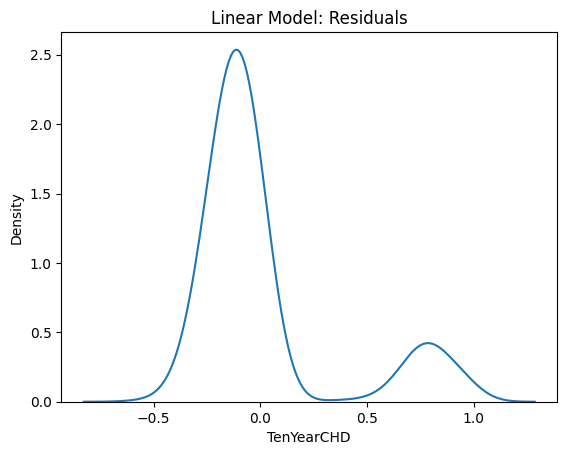


Logistic Regression rsq: 0.8584905660377359

Tree rsq:  0.8443396226415094
Confusion Matrix: 
 col_0         0   1
TenYearCHD         
0           888  15
1           150   7


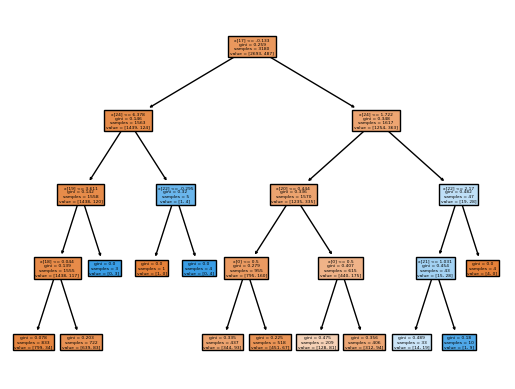

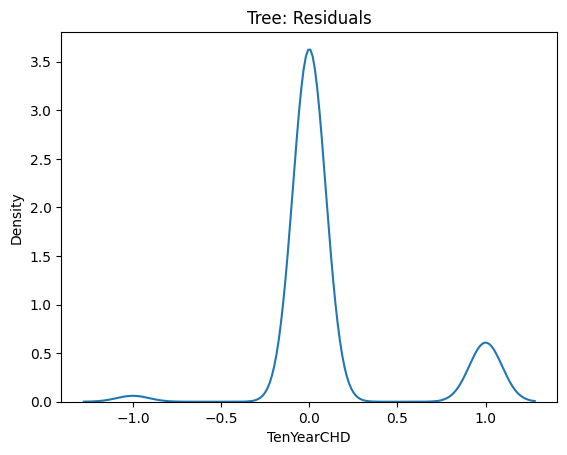

In [62]:
pipe(cat_vars, num_vars)

Here we can see with the variables we initially chose, the logistic regression model has the highest R-squared value of 0.85849 with the Decision Tree being very close at 0.84434

We then went on to try and look at how well do health conditions variables predict the possibility of getting CHD so we reduce the varianles to just those relating to health

Linear Model rsq:  0.06318867802215877
Slope Coefficients:  [ 4.75627043e+12  4.75627043e+12 -4.75627043e+12 -4.75627043e+12
  2.14571953e-02  7.45086670e-02 -2.71835327e-02  9.80377197e-04
 -6.00814819e-03  3.57971191e-02]
Intercept:  0.0


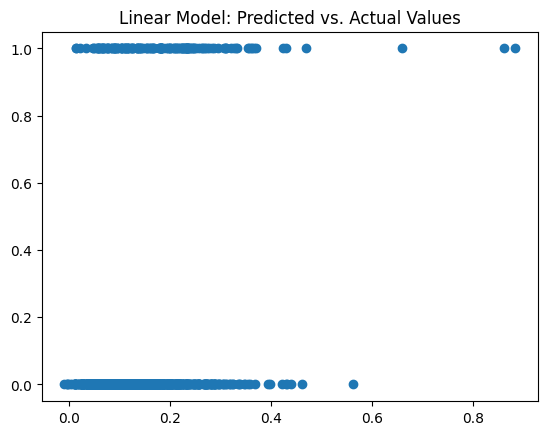

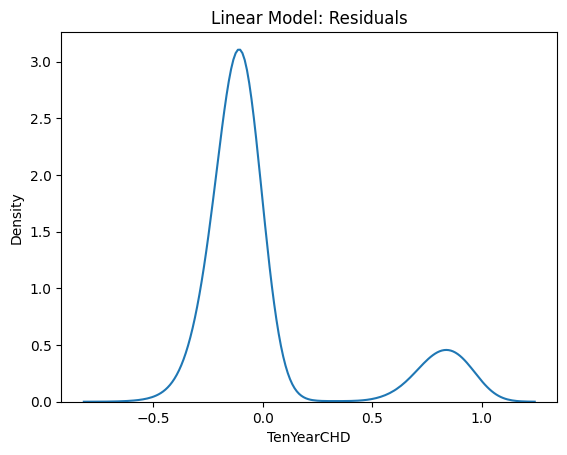


Logistic Regression rsq: 0.8518867924528302

Tree rsq:  0.8462264150943396
Confusion Matrix: 
 col_0         0   1
TenYearCHD         
0           890  13
1           150   7


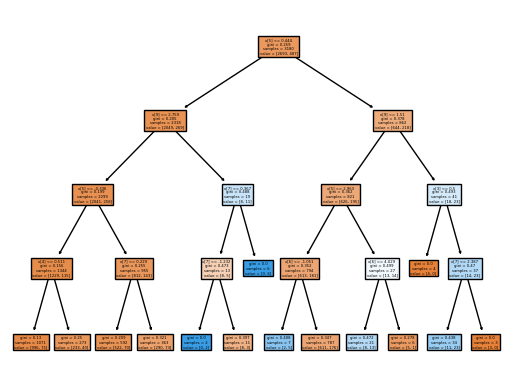

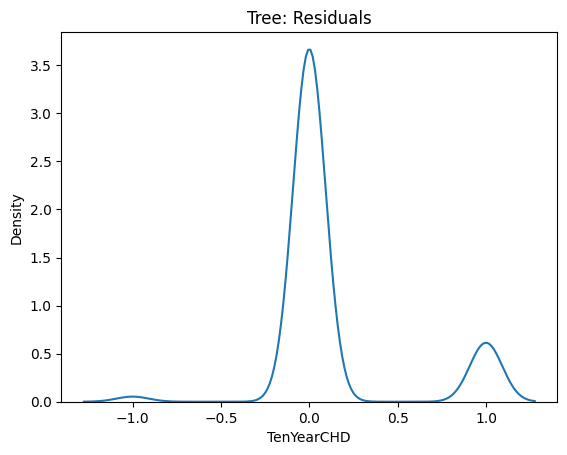

In [63]:
# cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
# num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

pipe(['prevalentStroke', 'prevalentHyp'], ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'])



Lastly, we examined how well does stroke and heart rate predict the possibility of getting CHD. The only variables used here were prevalentStroke and heartRate.


Linear Model rsq:  0.003861077403707891
Slope Coefficients:  [0.15129597 0.43124024 0.00891029]
Intercept:  0.0


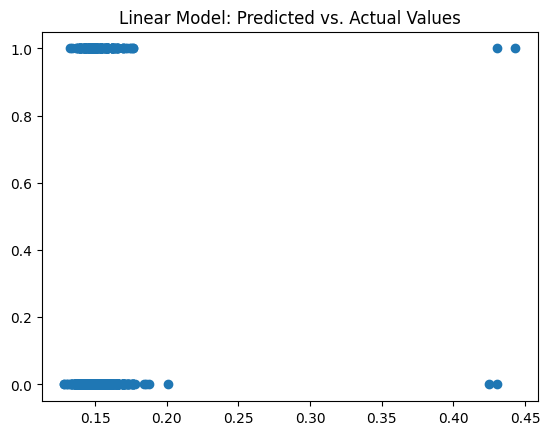

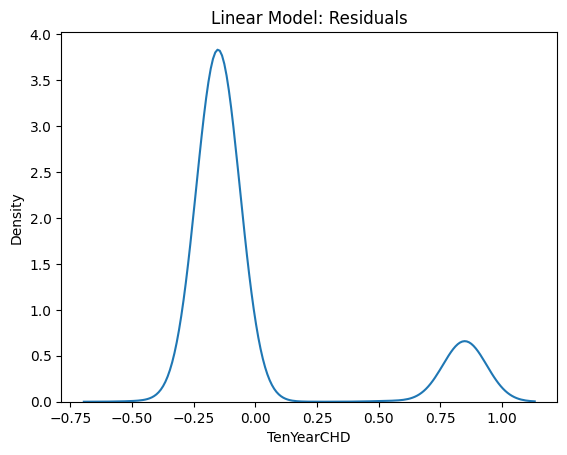


Logistic Regression rsq: 0.8518867924528302

Tree rsq:  0.8528301886792453
Confusion Matrix: 
 col_0         0  1
TenYearCHD        
0           903  0
1           156  1


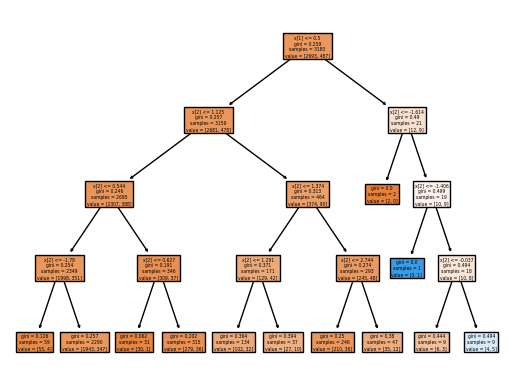

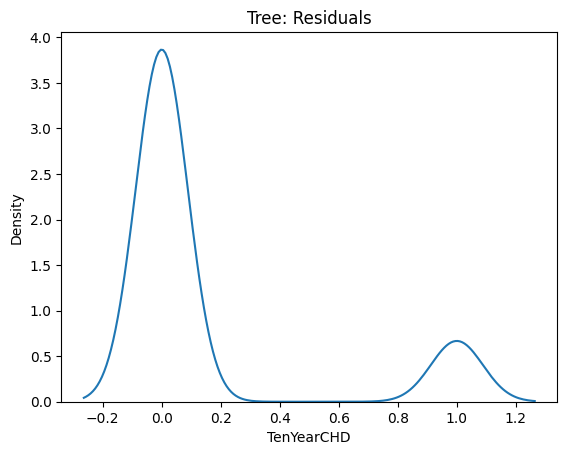

In [64]:
pipe(['prevalentStroke'], ['heartRate'])